In [2]:
# Core libraries
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn components
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error
from sklearn.base import clone

# Custom project modules
from source.Tools import setup_device_and_seed
from source.prepare_data import load_and_preprocess_data
from source.join_qh_min_data import join_qh_min_data

n_cores = joblib.cpu_count()

# Initialize device and seed
device_info = setup_device_and_seed(seed=987)
device = device_info["device"]


# Load data
qh, minute, hour = load_and_preprocess_data()


import numpy as np
def smape(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, np.finfo(float).eps, denominator)

    smape_values = 2 * numerator / denominator
    result = np.mean(smape_values)*100
    return result

def backtesting_CV_alt(
    model,
    data: pd.DataFrame,
    time_splits: TimeSeriesSplit,
    features: list,
    target: str,
    use_scaler: bool = True,
    n_jobs: int = -1,
    return_per_fold: bool = False,
):
    """
    Alternative backtesting using sklearn.cross_validate.

    Parameters:
      model        : sklearn estimator
      data         : DataFrame containing features+target
      time_splits  : TimeSeriesSplit instance
      features     : list of feature column names
      target       : name of target column
      use_scaler   : whether to wrap model in a StandardScaler pipeline
      n_jobs       : parallel jobs for cross_validate
      return_per_fold: if True, returns a DataFrame of per-sample predictions

    Returns:
      backtest_summary: DataFrame with one row per fold:
        [split, train_MAE, test_MAE, train_RMSE, test_RMSE, train_MAPE, test_MAPE]
      metrics: overall metrics dict same as your original API
      per_sample_df (optional): full y_test vs y_pred for all folds
    """
    start = perf_counter()
    X = data[features]
    y = data[target]

    # build pipeline
    estimator = make_pipeline(StandardScaler(), clone(model)) if use_scaler else clone(model)

    # define scorers
    def rmse(y_true, y_pred): return root_mean_squared_error(y_true, y_pred)
    def mape(y_true, y_pred):
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

    scorers = {
        'mae': make_scorer(mean_absolute_error, greater_is_better=True),
        'rmse': make_scorer(lambda y, y_pred: root_mean_squared_error(y, y_pred), greater_is_better=True),
        'mape': make_scorer(lambda y, y_pred: np.mean(np.abs((y - y_pred) / np.maximum(np.abs(y), np.finfo(float).eps))) * 100, greater_is_better=True),
        'smape': make_scorer(smape, greater_is_better=False),

    }

    cv_results = cross_validate(
        estimator, X, y,
        cv=time_splits,
        scoring=scorers,
        return_train_score=True,
        n_jobs=n_jobs,
        return_estimator=return_per_fold
    )
    calc_time = perf_counter() - start
    # Assemble a per-fold summary
    summary = []
    n_splits = time_splits.n_splits
    for i in range(n_splits):
        summary.append({
            'split': i,
            'train_MAE': cv_results['train_mae'][i],
            'test_MAE':  cv_results['test_mae'][i],
            'train_RMSE': cv_results['train_rmse'][i],
            'test_RMSE':  cv_results['test_rmse'][i],
            'train_MAPE': cv_results['train_mape'][i],
            'test_MAPE':  cv_results['test_mape'][i],
            'test_SMAPE': cv_results['test_smape'][i],
            'train_SMAPE': cv_results['train_smape'][i],
            'fit_time': cv_results['fit_time'][i],
            'score_time': cv_results['score_time'][i],
        })

    backtest_summary = pd.DataFrame(summary)
    # Overall metrics
    metrics = {
        'train_MAE':  backtest_summary['train_MAE'].mean(),
        'test_MAE':   backtest_summary['test_MAE'].mean(),
        'train_RMSE': backtest_summary['train_RMSE'].mean(),
        'test_RMSE':  backtest_summary['test_RMSE'].mean(),
        'train_MAPE': backtest_summary['train_MAPE'].mean(),
        'test_MAPE':  backtest_summary['test_MAPE'].mean(),
        'test_SMAPE': backtest_summary['test_SMAPE'].mean(),
        'train_SMAPE': backtest_summary['train_SMAPE'].mean(),
        'n_splits':   n_splits,
        'runtime_s': calc_time,
        'total_time_s': calc_time,
        'total_time_fit': backtest_summary['fit_time'].sum(),
        'total_time_score': backtest_summary['score_time'].sum(),
        'total_fold_cpu_time' : backtest_summary['fit_time'].sum() + backtest_summary['score_time'].sum(),
        'efficiency_estimate' : backtest_summary['fit_time'].sum() + backtest_summary['score_time'].sum() / (calc_time * n_cores)
    }

    if return_per_fold:
        # Collect per-sample predictions from each estimator
        per_sample = []
        for i, est in enumerate(cv_results['estimator']):
            train_idx, test_idx = list(time_splits.split(X))[i]
            y_pred = est.predict(X.iloc[test_idx])
            per_sample.append(pd.DataFrame({
                'y_test': y.iloc[test_idx].values,
                'y_pred': y_pred,
                'split': i
            }, index=y.iloc[test_idx].index))
        per_sample_df = pd.concat(per_sample)

        # ✅ Now it's safe to call smape and print detailed values
        print("SMAPE (manual):")
        manual_smape = smape(per_sample_df["y_test"], per_sample_df["y_pred"])
        print(manual_smape)

        return backtest_summary, metrics, per_sample_df



    return backtest_summary, metrics


MINUTE = 3
forecast_horizon = 1

qh_parameters= {'DayOfWeek_sin': {'lags': [0]}, 'GDV': {'lags': [-192, -1]}, 'IGCC-': {'lags': [-3, -2, -1]}, 'IP': {'lags': [-12, -11, -3, -2]}, 'LOAD_DA': {'lags': [-3, -1, 2]}, 'LOAD_ID_P90': {'lags': [-1, 2, 3]}, 'LOAD_ID': {'lags': [0]}, 'LOAD_RT': {'lags': [-4, -3]}, 'MDP': {'lags': [-3]}, 'MIP': {'lags': [-4]}, 'NETPOS_BE_ID': {'lags': [0, 1, 4, 8, 9, 13]}, 'NRV': {'lags': [-4, -3]}, 'SI': {'lags': [-97, -96, -25, -21, -5, -3, -1, 1]}, 'SOLAR_ID': {'lags': [2, 4]}, 'SOLAR_RT': {'lags': [-2, -1]}, 'WIND_P90': {'lags': [0, 1]}, 'WIND_RT': {'lags': [-10, -6, -4, -3, -2, -1]}, 'XB_DA_EXP_Germany': {'lags': [0, 1]}, 'XB_DA_EXP_Netherlands': {'lags': [-45, -38, 0, 1]}, 'XB_DA_EXP_UnitedKingdom': {'lags': [0]}, 'XB_DA_IMP_UnitedKingdom': {'lags': [0]}, 'XB_DA_NET_France': {'lags': [-1, 0, 1]}, 'XB_DA_NET_UnitedKingdom': {'lags': [-2, 1]}, 'XB_RT_Germany': {'lags': [-11]}, 'XB_RT_UnitedKingdom': {'lags': [-3]}, 'aFRR+': {'lags': [-96, -8, -6, -1]}, 'aFRR-': {'lags': [-3, -1]}}
minute_parameters= {'IGCC+_min': {'lags': [-2]}, 'MDP_min': {'lags': [-2]}, 'MIP_min': {'lags': [-2]}, 'NRV_min': {'lags': [-4]}, 'SI_min': {'lags': [-31, -5, -4, -3, -2]}}
hour_parameters= None


df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    hour_data=hour,
    hour_parameters=hour_parameters
)

df = df.dropna()
df.info(memory_usage="deep", verbose=False)

# Model
model_linear = LinearRegression()
if forecast_horizon == 1:
    TARGET = "SI_from_qh_plus_1"
if forecast_horizon == 0:
    TARGET = "system_imbalance_current_qh"
FEATURES = [feature for feature in df.columns if feature != TARGET]
# ----------------------------------------
# TimeSeries CV Setup
# ----------------------------------------
tscv = TimeSeriesSplit(n_splits=36, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 10, gap=0)

# ----------------------------------------
# Model Definitions
# ----------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from source.Tools import setup_device_and_seed
from source.prepare_data import load_and_preprocess_data
from source.join_qh_min_data import join_qh_min_data
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from time import perf_counter


# Step 1: Fit Linear Model to Get Coefficient Importances
init_model = Pipeline([
    ("scaler", StandardScaler()),
    ("linearregression", LinearRegression())
])
init_model.fit(df[FEATURES], df[TARGET])
coefs = init_model.named_steps['linearregression'].coef_
feature_weights = pd.Series(np.abs(coefs), index=FEATURES)

# Step 2: Select Least Important Features for PCA
N_PCA_FEATURES = 10
least_important = feature_weights.nsmallest(N_PCA_FEATURES).index.tolist()
most_important = [f for f in FEATURES if f not in least_important]

# Step 3: Run PCA on Least Important Features
results_grouped_pca = {}
n_least_options = list(range(0, 81, 5))  # Try 0 to 80 (max 76), step of 5
pca_component_settings = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30, 35, 40, 50, 0.9, 0.95]
results_grouped_pca = {}

for n_least in n_least_options:
    least_important = feature_weights.nsmallest(n_least).index.tolist()
    most_important = [f for f in FEATURES if f not in least_important]

    for n in pca_component_settings:
        if isinstance(n, int) and n > len(least_important):
            print(f"⚠️ Skipping config Least{n_least}_PCA_{n} — only {len(least_important)} features to reduce")
            continue  # Skip invalid config

        config_name = f"Least{n_least}_PCA_{n}"
        print(f"\n🔄 {config_name}")

        preprocessor_grouped = ColumnTransformer(transformers=[
            ("pca_least", Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=n))
            ]), least_important),
            ("rest", "passthrough", most_important)
        ])

        model_grouped_pca = Pipeline([
            ("preprocessor", preprocessor_grouped),
            ("regressor", LinearRegression())
        ])

        try:
            start = perf_counter()
            results, metrics = backtesting_CV_alt(
                model=model_grouped_pca,
                data=df,
                time_splits=tscv,
                features=FEATURES,
                target=TARGET,
                use_scaler=False
            )
            duration = perf_counter() - start

            preprocessor_grouped.fit(df[FEATURES])
            pca_obj = preprocessor_grouped.named_transformers_['pca_least'].named_steps['pca']
            n_pca = pca_obj.n_components_ if hasattr(pca_obj, "n_components_") else pca_obj.n_components
            n_total = n_pca + len(most_important)

            metrics["n_features_after_PCA"] = n_total
            metrics["config"] = config_name
            metrics["runtime_s"] = duration
            results_grouped_pca[config_name] = metrics

            print(f"  ⏱️ Runtime: {duration:.2f}s")
            print(
                f"  📉 MAE: {metrics['test_MAE']:.2f}, RMSE: {metrics['test_RMSE']:.2f}, SMAPE: {metrics['test_SMAPE']:.2f}")

        except ValueError as e:
            print(f"❌ Failed: {config_name} — {e}")
            continue
# ----------------------------------------
# Evaluation Loop
# ----------------------------------------
results_all = {}
baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])
results, metrics = backtesting_CV_alt(
    model=baseline_model,
    data=df,
    time_splits=tscv,
    features=FEATURES,
    target=TARGET,
    use_scaler=False
)
results_all["OriginalModel"] = metrics

# ----------------------------------------
# Summary Table
# ----------------------------------------
df_grouped_summary = pd.DataFrame(results_grouped_pca).T[
    ["test_MAE", "test_RMSE", "test_MAPE", "test_SMAPE", "runtime_s"]
]
df_grouped_summary.columns = ["MAE", "RMSE", "MAPE (%)", "SMAPE (%)", "Time (s)"]

df_grouped_summary["n_features"] = [
    results_grouped_pca[k]["n_features_after_PCA"]
    if k in results_grouped_pca else results_all[k].get("n_features_after_PCA", np.nan)
    for k in df_grouped_summary.index
]

df_grouped_summary = df_grouped_summary.sort_values("n_features")

# Add original models to grouped PCA results for comparison
for name, metrics in results_all.items():
    if "runtime_s" in metrics:
        df_grouped_summary.loc[name] = [
            metrics["test_MAE"],
            metrics["test_RMSE"],
            metrics["test_MAPE"],
            metrics["test_SMAPE"],
            metrics["runtime_s"],
            len(FEATURES)  # or any number you'd like to indicate for 'n_features'
        ]

    else:  # fallback if only total_time_s is available
        df_grouped_summary.loc[name] = [
            metrics["test_MAE"],
            metrics["test_RMSE"],
            metrics["test_MAPE"],
            metrics["test_SMAPE"],
            metrics["runtime_s"],
            len(FEATURES)  # or any number you'd like to indicate for 'n_features'
        ]

print("\n📊 Summary of Grouped PCA Results:\n")
print(df_grouped_summary.round(3))



Using device: cuda
Current device index: 0, GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\quarter_hours_data_2022.01.01_to_2024.01.01.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\minutes_data_2022.01.01_to_2024.01.01.h5
Loading data from: C:\Users\jds\OneDrive - KU Leuven\Ku Leuven\Master Semester 5\Thesis\Elia\CSV\hours_data_2022.01.01_to_2024.01.01.h5
Frequency identified as: qh
Frequency identified as: minute
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69840 entries, 2022-01-03 00:03:00+00:00 to 2023-12-31 20:33:00+00:00
Columns: 79 entries, DayOfWeek_sin_current_qh to SI_min_from_minute_minus_2
dtypes: float64(79)
memory usage: 42.6 MB
⚠️ Skipping config Least0_PCA_1 — only 0 features to reduce
⚠️ Skipping config Least0_PCA_2 — only 0 features to reduce
⚠️ Skipping config Least0_PCA_3 — only 0 features to reduce
⚠️ Skipp

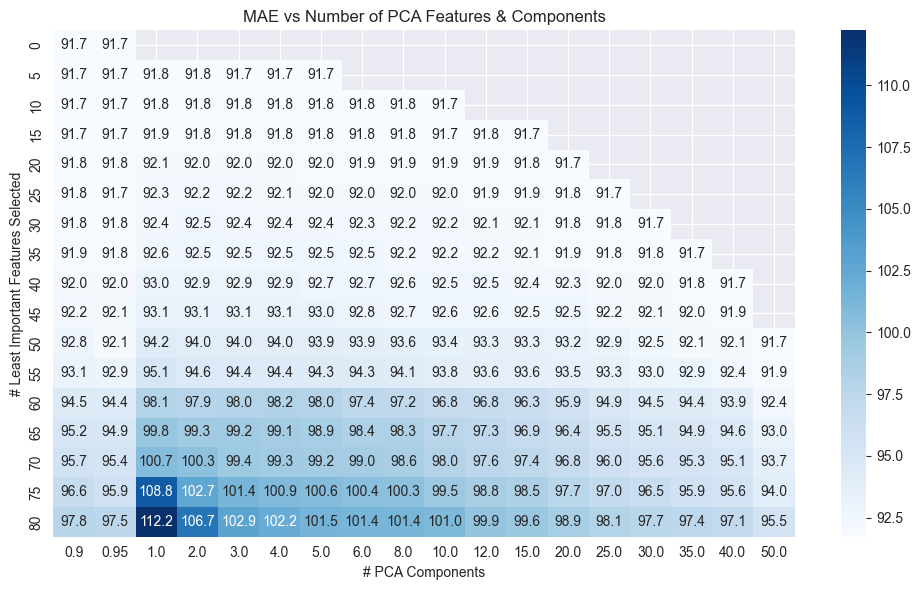

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract split values
summary_heat = pd.DataFrame([
    {
        "n_least": int(k.split("Least")[1].split("_")[0]),
        "n_components": (
            float(k.split("_PCA_")[1])
            if "." in k.split("_PCA_")[1]
            else int(k.split("_PCA_")[1])
        ),
        "MAE": v["test_MAE"],
        "RMSE": v["test_RMSE"],
        "Runtime": v["runtime_s"]
    }
    for k, v in results_grouped_pca.items()
])

# Plot MAE heatmap
heat = summary_heat.pivot(index="n_least", columns="n_components", values="MAE")
plt.figure(figsize=(10, 6))
sns.heatmap(heat, annot=True, fmt=".1f", cmap="Blues")
plt.title("MAE vs Number of PCA Features & Components")
plt.ylabel("# Least Important Features Selected")
plt.xlabel("# PCA Components")
plt.tight_layout()
plt.show()

In [10]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter points
sc = ax.scatter(
    summary_heat["n_least"],
    summary_heat["n_components"],
    summary_heat["MAE"],
    c=summary_heat["Runtime"],
    cmap="plasma",
    s=60
)

# Axis labels
ax.set_xlabel("# Least Important Features")
ax.set_ylabel("# PCA Components")
ax.set_zlabel("MAE")
ax.set_title("MAE vs PCA Feature Count vs Components (baseline as plane)")

# Add runtime colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Runtime (s)")

# Baseline MAE plane
baseline_mae = results_all["OriginalModel"]["test_MAE"]

# Create meshgrid that spans the data range
x_range = np.linspace(summary_heat["n_least"].min(), summary_heat["n_least"].max(), 10)
y_range = np.linspace(summary_heat["n_components"].min(), summary_heat["n_components"].max(), 10)
X, Y = np.meshgrid(x_range, y_range)
Z = np.full_like(X, baseline_mae)

# Plot the surface
ax.plot_surface(X, Y, Z, alpha=0.2, color='red', label="Baseline MAE")

# Optional legend (workaround)
from matplotlib.lines import Line2D
custom_line = [Line2D([0], [0], color='red', lw=4, alpha=0.3)]
ax.legend(custom_line, ['Baseline MAE'])

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter: Runtime vs PCA config
sc = ax.scatter(
    summary_heat["n_least"],
    summary_heat["n_components"],
    summary_heat["Runtime"],
    c=summary_heat["Runtime"],
    cmap="inferno",
    s=60
)

# Axis labels
ax.set_xlabel("# Least Important Features")
ax.set_ylabel("# PCA Components")
ax.set_zlabel("Runtime (s)")
ax.set_title("Runtime vs PCA Feature Count vs Components")

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label("Runtime (s)")

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>

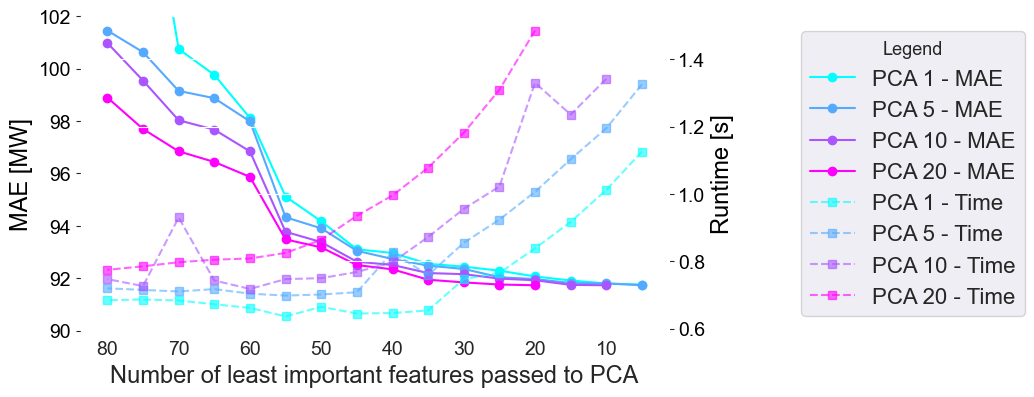

In [41]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 17,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'legend.title_fontsize': 13
})
# Limit to selected PCA values
pca_values = [1, 5, 10, 20]
colors = plt.cm.cool(np.linspace(0, 1, len(pca_values)))


fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()  # Define this ONCE
# Remove grey background and set white background
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax2.set_facecolor('white')
mae_lines = []
runtime_lines = []

for color, p in zip(colors, pca_values):
    subset = summary_heat[summary_heat["n_components"] == p]

    # MAE line on ax1
    line1, = ax1.plot(
        subset["n_least"], subset["MAE"],
        marker='o', linestyle='-', color=color,
        label=f"PCA {p} - MAE"
    )
    mae_lines.append(line1)

    # Runtime line on ax2
    line2, = ax2.plot(
        subset["n_least"], subset["Runtime"],
        marker='s', linestyle='--', color=color,
        label=f"PCA {p} - Time", alpha=0.6
    )
    runtime_lines.append(line2)

# Axis labels and formatting
ax1.set_xlabel("Number of least important features passed to PCA")
ax1.set_ylabel("MAE [MW]", color="black")
ax2.set_ylabel("Runtime [s]", color="black")
ax1.tick_params(axis='y', labelcolor="black")
ax2.tick_params(axis='y', labelcolor="black")
ax1.grid(axis="y", linestyle="--", alpha=0.5)
ax1.set_ylim(90, 102)  # Adjust the range as needed

# Flip x-axis
ax1.invert_xaxis()

# Combine legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    handles1 + handles2,
    labels1 + labels2,
    title="Legend",
    loc="center left",
    bbox_to_anchor=(1.15, 0.5), # Increased from 1.02 to 1.15
    borderaxespad=2
)
plt.tight_layout(pad=8)  # Adds more space around elements
plt.show()


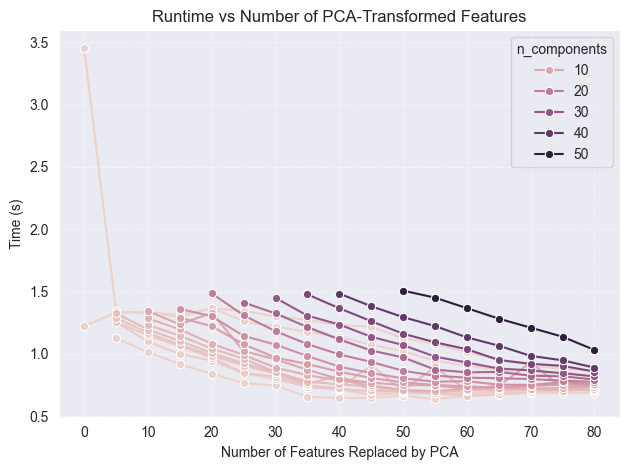

In [7]:
sns.lineplot(data=summary_heat, x="n_least", y="Runtime", hue="n_components", marker="o")
plt.title("Runtime vs Number of PCA-Transformed Features")
plt.ylabel("Time (s)")
plt.xlabel("Number of Features Replaced by PCA")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
